In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
from sklearn.decomposition import PCA


import torchvision
from torchvision import datasets, transforms
from torch.nn.parameter import Parameter
import helper
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
from torch.optim import SGD
import sys
from torch.optim.lr_scheduler import ExponentialLR
import torchvision.models as models
from torch.autograd import Variable

import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report,accuracy_score
from google.colab import files
import copy
from google.colab import drive
import time
import json
import numpy as np
from collections import OrderedDict
import csv
import glob
import matplotlib.pyplot as plt
import pickle
import os
import pandas as pd

drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
path_to_training_text_embedding = 'drive/MyDrive/deepweeds_data_zsl/text_embeddings/deepweeds_text_embeddings_train.csv'
path_to_training_image_embedding = 'drive/MyDrive/deepweeds_data_zsl/image_embeddings/deepweeds_image_embeddings_train.csv'
path_to_groundtruth = 'drive/MyDrive/deepweeds_data_zsl/ground_truth_text_embeddings.csv'

## get ground truth semantic labels

In [3]:
text_embed_array = np.genfromtxt(path_to_training_text_embedding, delimiter=',')
image_embed_array = np.genfromtxt(path_to_training_image_embedding, delimiter=',')
train_labels = np.genfromtxt('drive/MyDrive/deepweeds_data_zsl/labels/deepweeds_labels_train.csv', delimiter=',')
groundtruth_labels = np.genfromtxt(path_to_groundtruth, delimiter=',')
test_image_embeddings = np.genfromtxt("drive/MyDrive/deepweeds_data_zsl/image_embeddings/deepweeds_image_embeddings_test.csv", delimiter=",")
test_labels = np.genfromtxt("drive/MyDrive/deepweeds_data_zsl/labels/deepweeds_labels_test.csv", delimiter=",")

In [4]:
import random
# remove unseen classes from the set
loc_cl1 = list(np.where(test_labels == 4)[0]) 
loc_cl2 = list(np.where(test_labels == 5)[0])

# negative sampling
permuts_cl1 = random.sample(loc_cl1, len(loc_cl1) - 250)
permuts_cl2 = random.sample(loc_cl2, len(loc_cl2) - 250)
permuts = permuts_cl1 + permuts_cl2
test_labels = np.delete(test_labels, permuts, axis=0)
test_image_embeddings = np.delete(test_image_embeddings, permuts, axis=0)

In [5]:
#issues in the test labels - labels 4,5 at training correspond to 6,7 at test

test_labels = np.where(test_labels == 4,10, test_labels)
test_labels = np.where(test_labels == 5,11, test_labels)
test_labels = np.where(test_labels == 6,4, test_labels)
test_labels = np.where(test_labels == 7,5, test_labels)
test_labels = np.where(test_labels == 10,6, test_labels)
test_labels = np.where(test_labels == 11,7, test_labels)


In [6]:
input_dim = 2048
output_dim = 50
tensor_y = torch.Tensor((text_embed_array))
tensor_x = torch.Tensor(image_embed_array)

In [7]:


def train_val_dataset(dataset, val_split=0.1):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

dataset = torch.utils.data.TensorDataset(tensor_x,tensor_y) # create your dataset
dataset = train_val_dataset(dataset)
batch_size = 10

dataloader = {x: torch.utils.data.DataLoader(dataset[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}

## Models

In [9]:
class MultiDimensionalRegression(nn.Module):
    def __init__(self,input_size,out_size):
        super(MultiDimensionalRegression, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size,1024),
            nn.ReLU(),
            nn.Linear(1024,512),
            nn.ReLU(), 
            nn.Linear(512, 256), 
            nn.ReLU(), 
            nn.Linear(256,128),
            nn.ReLU(), 
            nn.Linear(128,64),
            nn.ReLU(), 
            nn.Linear(64,32),
            nn.ReLU(), 
            nn.Linear(32,16))
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, out_size))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [8]:
from tqdm import trange
from tqdm import tqdm

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [10]:

def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=20, is_inception=False):
    since = time.time()

    val_acc_history = []
    train_acc_history = []

    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            with tqdm(dataloaders[phase],unit = 'batch') as tepoch:
              # Iterate over data.
              for inputs, labels in tepoch:
                  inputs = inputs.to(device)
                  labels = labels.to(device)
                  # forward
                  # track history if only in train
                  with torch.set_grad_enabled(phase == 'train'):
                      # Get model outputs and calculate loss
                      # Special case for inception because in training it has an auxiliary output. In train
                      #   mode we calculate the loss by summing the final output and the auxiliary output
                      #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                      # zero the parameter gradients
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                  

                  # statistics
                  running_loss += loss.item() 

              epoch_loss = running_loss / len(dataloaders[phase].dataset)
              if phase == 'train':
                  scheduler.step()
                  print("Current Learning Rate = ",optimizer.param_groups[0]["lr"])
                  print()  


              print('{} Loss: {}'.format(phase, epoch_loss))
              print()
              # # deep copy the model
              # if phase == 'val' and epoch_acc > best_acc:
              #     best_acc = epoch_acc
              #     best_model_wts = copy.deepcopy(model.state_dict())
              if phase == 'val':
                  val_acc_history.append(epoch_loss)
              if phase == 'train':
                  train_acc_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    return model, val_acc_history, train_acc_history

In [11]:
mdr = MultiDimensionalRegression(input_dim,output_dim)
# send model to GPU
if torch.cuda.is_available():
    mdr.cuda()

criterion = nn.MSELoss()

In [12]:
# params_to_update = mdr.parameters()
# optimizer = torch.optim.Adam(params_to_update, lr=0.001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


# ae_trained_model, ae_balanced_val_hist, ae_balanced_tr_hist  = train_model(mdr, dataset, criterion, optimizer,scheduler,  num_epochs= 100)
# torch.save(ae_trained_model.state_dict(), 'ae_100_epochs')
# files.download('ae_100_epochs')
# params_to_update = ff_net.parameters()
# optimizer = optim.Adam(params_to_update, lr=0.001)

# ff_trained_model, ff_balanced_val_hist, ff_balanced_tr_hist  = train_model(ff_net, dataset, criterion, optimizer, scheduler, num_epochs= 100)

# torch.save(ff_trained_model.state_dict(), 'ff_100_epochs')
# files.download('ff_100_epochs')

In [14]:
# Plotting AE training and validation performance
# ae_val = [val for val in ae_balanced_val_hist]
# ae_train = [val for val in ae_balanced_tr_hist]

# plt.plot(ae_val,'b-', label='Validation MSE loss')
# #plt.plot(ae_train,'b--', label='AE training MSE loss')
# plt.legend()
# plt.show()


# # Plotting FF training and validation performance
# ff_val = [val for val in ff_balanced_val_hist]
# ff_train = [val for val in ff_balanced_tr_hist]

# plt.plot(ff_val,'g-', label='FF validation MSE loss')
# plt.plot(ff_train,'g--', label='f training MSE loss')
# plt.legend()
# plt.show()

#Testing

In [15]:
criterion = nn.MSELoss()
model_to_test = MultiDimensionalRegression(input_dim, output_dim)
model_to_test.load_state_dict(torch.load('drive/MyDrive/trained_models/ae_100_epochs'))

if torch.cuda.is_available():
    model_to_test.cuda()
    
model_to_test.eval()

# for inputs, labels in dataloader['val']:
#   labels= labels.to(device)
#   output = model_to_test(inputs.to(device))
#   print(output)
#   print(criterion(output, labels))



ae_predicted_labels = np.zeros((len(test_image_embeddings),output_dim))
model_to_test.eval()
err = 0
with torch.no_grad():
  for i in range(len(test_image_embeddings)):

    input = (torch.Tensor(test_image_embeddings[i])).to(device)
    output = model_to_test(input)
    true = (torch.Tensor(groundtruth_labels[int(test_labels[i])])).to(device)
    loss = criterion(output, true).cpu().data.numpy()
    pred = np.asarray(output.cpu().data.numpy())
    ae_predicted_labels[i,:] = pred
    
    err += loss
  
print('Average testing MSE for the MultiDimensionalRegression model:',err/len(test_image_embeddings))
#0.001692089332007746

Average testing MSE for the Autoencoder model: 0.0010689628183504195


In [ ]:

# ff_predicted_labels = np.zeros((len(test_image_embeddings),output_dim))
# ff_trained_model.eval()
# err = 0
# for i in range(len(test_image_embeddings)):
#   input = (torch.Tensor(test_image_embeddings[i])).to(device)
#   pred = ff_trained_model(input)


#   ff_predicted_labels[i,:] = np.asarray(pred.cpu().data.numpy())

#   pred = ff_predicted_labels[i,:]
#   true = groundtruth_labels[int(test_labels[i])]

#   err += sum((pred-true)**2)/len(pred)
  
# print('Average testing MSE for the Feed Forward model:',err/len(test_image_embeddings))


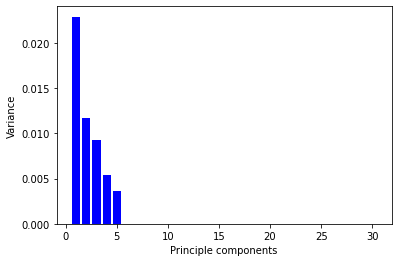

[2.29287387e-02 1.16870121e-02 9.27214225e-03 5.40569387e-03
 3.59295895e-03 1.27336163e-31 9.11124193e-32 6.23079605e-32
 4.56377302e-32 3.54144789e-32 1.49775842e-32 1.35574862e-34
 1.35574862e-34 1.35574862e-34 1.35574862e-34 1.35574862e-34
 1.35574862e-34 1.35574862e-34 1.35574862e-34 1.35574862e-34
 1.35574862e-34 1.35574862e-34 1.35574862e-34 1.35574862e-34
 1.35574862e-34 1.35574862e-34 1.35574862e-34 1.35574862e-34
 1.35574862e-34 1.35574862e-34 1.35574862e-34 1.35574862e-34
 1.35574862e-34 1.35574862e-34 1.35574862e-34 1.35574862e-34
 1.35574862e-34 1.35574862e-34 1.35574862e-34 1.35574862e-34
 1.35574862e-34 1.35574862e-34 1.35574862e-34 1.35574862e-34
 1.35574862e-34 1.35574862e-34 1.35574862e-34 1.35574862e-34
 1.35574862e-34 2.03568787e-39]
3.8193818335377322e-31


In [16]:
dims= 50
reducer = PCA(n_components=dims)
reduced_known_labels = reducer.fit_transform(text_embed_array)

reduced_predicted_labels = reducer.transform(ae_predicted_labels)

reduced_groundtruth_labels = reducer.transform(groundtruth_labels)

dims= np.linspace(1,30,30)
for i in range(len(dims)):
  plt.bar(dims[i], height = reducer.explained_variance_[i], color= 'b')
plt.ylabel('Variance')
plt.xlabel('Principle components')
plt.show()
print(reducer.explained_variance_)
print(sum(reducer.explained_variance_[5:]))

NameError: ignored

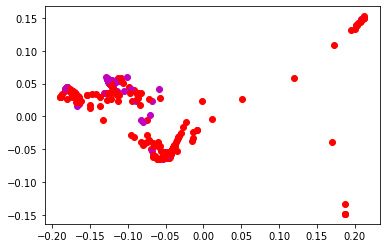

In [ ]:
# Plot 2D projection space
# 2D plot of the clusters

for i in range(len(test_labels)):
  if test_labels[i] == 4:
    plt.scatter(reduced_predicted_labels[:,0][i], reduced_predicted_labels[:,1][i], c = 'm')
  elif test_labels[i] == 7:
    plt.scatter(reduced_predicted_labels[:,0][i], reduced_predicted_labels[:,1][i], c = 'r')

for i in range(len(groundtruth_labels)):
  if i == 4:
    plt.scatter(reduced_groundtruth_labels[:,0][i], reduced_groundtruth_labels[:,1][i], c = 'b', marker = '*', label = class_names[i])
  elif i == 7:
    plt.scatter(reduced_groundtruth_labels[:,0][i], reduced_groundtruth_labels[:,1][i], c = 'b', marker = '*', label = class_names[i])
  # elif test_labels[i] == 2:
  #   plt.scatter(reduced_predicted_labels[:,0][i], reduced_predicted_labels[:,1][i], c = 'g')
  # elif test_labels[i] == 3:
  #   plt.scatter(reduced_predicted_labels[:,0][i], reduced_predicted_labels[:,1][i], c = 'b')
  # elif test_labels[i] == 4:
  #   plt.scatter(reduced_predicted_labels[:,0][i], reduced_predicted_labels[:,1][i], c = 'y')
  # elif test_labels[i] == 5:
  #   plt.scatter(reduced_predicted_labels[:,0][i], reduced_predicted_labels[:,1][i], c = 'salmon')
plt.show()


# # adding noise to the reduced known labels
# print(np.random.normal(0,0.1,dims))
# print(reduced_known_labels[0,:].shape)
# for i in range(reduced_known_labels.shape[0]):
#   #print(reduced_known_labels[i,:])
#   reduced_known_labels[i,:] += np.random.normal(0,0.05,(reduced_known_labels).shape[1])
#   #print(reduced_known_labels[i,:])
#   plt.scatter(reduced_known_labels[i][0],reduced_known_labels[i][1], label = 'projected points')
# plt.show()

## Label Propagation

In [17]:
class_names = ['Chinee Apple', 'Lantana', 'Parkinsonia', 'Parthenium', 'Siam Weed', 'Snake Weed', 'Prickly Acacia', 'Rubber Vine']

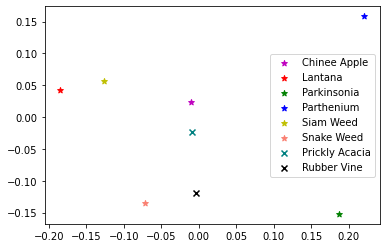

In [ ]:
for i in range(len(groundtruth_labels)):
  if i == 0:
    plt.scatter(reduced_groundtruth_labels[:,0][i], reduced_groundtruth_labels[:,1][i], c = 'm', marker = '*', label = class_names[i])
  elif i == 1:
    plt.scatter(reduced_groundtruth_labels[:,0][i], reduced_groundtruth_labels[:,1][i], c = 'r', marker = '*', label = class_names[i])
  elif i == 2:
    plt.scatter(reduced_groundtruth_labels[:,0][i], reduced_groundtruth_labels[:,1][i], c = 'g', marker = '*', label = class_names[i])
  elif i == 3:
    plt.scatter(reduced_groundtruth_labels[:,0][i], reduced_groundtruth_labels[:,1][i], c = 'b', marker = '*', label = class_names[i])
  elif i == 4:
    plt.scatter(reduced_groundtruth_labels[:,0][i], reduced_groundtruth_labels[:,1][i], c = 'y', marker = '*', label = class_names[i])
  elif i == 5:
    plt.scatter(reduced_groundtruth_labels[:,0][i], reduced_groundtruth_labels[:,1][i], c = 'salmon', marker = '*', label = class_names[i])
  elif i == 6:
    plt.scatter(reduced_groundtruth_labels[:,0][i], reduced_groundtruth_labels[:,1][i], c = 'teal', marker = 'x', label = class_names[i])
  elif i == 7:
    plt.scatter(reduced_groundtruth_labels[:,0][i], reduced_groundtruth_labels[:,1][i], c = 'black', marker = 'x', label = class_names[i])
plt.legend()

plt.savefig('gt_as_centroids.png')
plt.show()


In [ ]:
from sklearn.semi_supervised import LabelPropagation
from sklearn.metrics import classification_report, accuracy_score
label_vals = np.linspace(0,7,8)
dimensions = np.linspace(2,50,49)
accuracies = []
params = []

# SEARCH FOR BEST PERFORMING MODEL

for j in dimensions:
  reducer = PCA(n_components=int(j))
  reduced_known_labels = reducer.fit_transform(text_embed_array)

  reduced_predicted_labels = reducer.transform(ae_predicted_labels)

  reduced_groundtruth_labels = reducer.transform(groundtruth_labels)

  
  for n in np.linspace(1,7,7):    

    label_prop_model = LabelPropagation(kernel='knn', gamma = int(n), n_neighbors = int(n))
    label_prop_model.fit(reduced_groundtruth_labels, label_vals)
    lp_predictions = label_prop_model.predict(reduced_predicted_labels)
    acc = (accuracy_score(test_labels,lp_predictions))
    accuracies.append(acc)
    params.append(list([j,n]))

  label_prop_model = LabelPropagation(kernel='knn', n_neighbors = 1)
  label_prop_model.fit(reduced_groundtruth_labels, label_vals)
  lp_predictions = label_prop_model.predict(reduced_predicted_labels)
  acc = (accuracy_score(test_labels,lp_predictions))
  accuracies.append(acc)
  params.append(list([j,n]))


# RETURN RESULTS OF BEST PERFORMING MODEL
print('Maximum accuracy of {} when d= {} and n= {}'.format(max(accuracies), params[int(np.argmax(accuracies))][0], params[int(np.argmax(accuracies))][1]))
reducer = PCA(n_components=int(params[int(np.argmax(accuracies))][0]))
reduced_known_labels = reducer.fit_transform(text_embed_array)
reduced_predicted_labels = reducer.transform(ae_predicted_labels)
reduced_groundtruth_labels = reducer.transform(groundtruth_labels)
      
label_prop_model = LabelPropagation(kernel='knn', n_neighbors = int(params[int(np.argmax(accuracies))][1]))
label_prop_model.fit(reduced_groundtruth_labels, label_vals)
lp_predictions = label_prop_model.predict(reduced_predicted_labels)
#print(np.unique(label_prop_model.predict_proba(reduced_predicted_labels)))
print(classification_report(test_labels,lp_predictions, target_names= class_names))

      

Maximum accuracy of 0.5527210884353742 when d= 11.0 and n= 1.0
[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
                precision    recall  f1-score   support

  Chinee Apple       0.48      0.56      0.52       225
       Lantana       0.68      0.82      0.74       212
   Parkinsonia       0.67      0.94      0.78       206
    Parthenium       0.49      0.88      0.63       204
     Siam Weed       0.71      0.94      0.81       214
    Snake Weed       0.33      0.49      0.39       203
Prickly Acacia       0.00      0.00      0.00       250
   Rubber Vine       0.50      0.00      0.01       250

      accuracy                           0.55      1764
     macro avg       0.48      0.58      0.49      1764
  weighted avg       0.47      0.55      0.46      1764



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0. 1.]


## NearestCentroid clustering


In [40]:
# NearestCentroid clustering

def NearestCentroid(projections,centroids):
  'computes the distance of every point to a centroid'
  preds = []
  for point in projections:
    distances = [np.linalg.norm(point-gt) for gt in centroids]
    preds.append(np.argmin(distances))
  return preds


dims= np.linspace(2,50,49)
a = []
for d in dims:

  reducer = PCA(n_components=int(d))
  reduced_known_labels = reducer.fit_transform(text_embed_array)

  reduced_predicted_labels = reducer.transform(ae_predicted_labels)

  reduced_groundtruth_labels = reducer.transform(groundtruth_labels)

  nc_predictions = NearestCentroid(reduced_predicted_labels,reduced_groundtruth_labels)
  acc= accuracy_score(test_labels,nc_predictions)
  #print(classification_report(test_labels,nc_predictions, target_names= class_names))
  print('Accuracy for a NC classifier in {} dimensions: '.format(int(d)), acc)
  a.append(acc)
  print(classification_report(test_labels,nc_predictions, target_names= class_names))

Accuracy for a NC classifier in 2 dimensions:  0.43253968253968256
                precision    recall  f1-score   support

  Chinee Apple       0.15      0.02      0.03       225
       Lantana       0.71      0.77      0.74       212
   Parkinsonia       0.68      0.95      0.79       206
    Parthenium       0.50      0.87      0.64       204
     Siam Weed       0.66      0.93      0.77       214
    Snake Weed       0.00      0.00      0.00       203
Prickly Acacia       0.04      0.10      0.06       250
   Rubber Vine       0.00      0.00      0.00       250

      accuracy                           0.43      1764
     macro avg       0.34      0.45      0.38      1764
  weighted avg       0.33      0.43      0.36      1764

Accuracy for a NC classifier in 3 dimensions:  0.546485260770975
                precision    recall  f1-score   support

  Chinee Apple       0.47      0.58      0.52       225
       Lantana       0.69      0.79      0.74       212
   Parkinsonia       0.6

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Accuracy for a NC classifier in 4 dimensions:  0.48639455782312924
                precision    recall  f1-score   support

  Chinee Apple       0.40      0.10      0.16       225
       Lantana       0.69      0.79      0.74       212
   Parkinsonia       0.68      0.94      0.79       206
    Parthenium       0.49      0.88      0.63       204
     Siam Weed       0.64      0.94      0.76       214
    Snake Weed       0.29      0.08      0.12       203
Prickly Acacia       0.00      0.00      0.00       250
   Rubber Vine       0.21      0.30      0.25       250

      accuracy                           0.49      1764
     macro avg       0.43      0.51      0.43      1764
  weighted avg       0.41      0.49      0.42      1764

Accuracy for a NC classifier in 5 dimensions:  0.5096371882086168
                precision    recall  f1-score   support

  Chinee Apple       0.48      0.27      0.35       225
       Lantana       0.69      0.82      0.75       212
   Parkinsonia       0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Accuracy for a NC classifier in 6 dimensions:  0.5096371882086168
                precision    recall  f1-score   support

  Chinee Apple       0.48      0.27      0.35       225
       Lantana       0.69      0.82      0.75       212
   Parkinsonia       0.68      0.94      0.79       206
    Parthenium       0.49      0.88      0.63       204
     Siam Weed       0.70      0.94      0.81       214
    Snake Weed       0.27      0.16      0.20       203
Prickly Acacia       0.00      0.00      0.00       250
   Rubber Vine       0.17      0.22      0.20       250

      accuracy                           0.51      1764
     macro avg       0.43      0.53      0.46      1764
  weighted avg       0.42      0.51      0.45      1764

Accuracy for a NC classifier in 7 dimensions:  0.5119047619047619
                precision    recall  f1-score   support

  Chinee Apple       0.48      0.29      0.36       225
       Lantana       0.69      0.82      0.75       212
   Parkinsonia       0.6

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Accuracy for a NC classifier in 8 dimensions:  0.5119047619047619
                precision    recall  f1-score   support

  Chinee Apple       0.48      0.30      0.37       225
       Lantana       0.69      0.82      0.75       212
   Parkinsonia       0.68      0.94      0.79       206
    Parthenium       0.49      0.88      0.63       204
     Siam Weed       0.70      0.94      0.81       214
    Snake Weed       0.26      0.18      0.21       203
Prickly Acacia       0.00      0.00      0.00       250
   Rubber Vine       0.17      0.20      0.18       250

      accuracy                           0.51      1764
     macro avg       0.43      0.53      0.47      1764
  weighted avg       0.42      0.51      0.45      1764

Accuracy for a NC classifier in 9 dimensions:  0.5113378684807256
                precision    recall  f1-score   support

  Chinee Apple       0.48      0.28      0.35       225
       Lantana       0.69      0.82      0.75       212
   Parkinsonia       0.6

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Accuracy for a NC classifier in 10 dimensions:  0.5413832199546486
                precision    recall  f1-score   support

  Chinee Apple       0.48      0.49      0.49       225
       Lantana       0.69      0.82      0.75       212
   Parkinsonia       0.68      0.94      0.79       206
    Parthenium       0.49      0.88      0.63       204
     Siam Weed       0.70      0.94      0.81       214
    Snake Weed       0.31      0.42      0.36       203
Prickly Acacia       0.00      0.00      0.00       250
   Rubber Vine       0.15      0.04      0.07       250

      accuracy                           0.54      1764
     macro avg       0.44      0.57      0.49      1764
  weighted avg       0.42      0.54      0.47      1764

Accuracy for a NC classifier in 11 dimensions:  0.5170068027210885
                precision    recall  f1-score   support

  Chinee Apple       0.47      0.33      0.39       225
       Lantana       0.69      0.82      0.75       212
   Parkinsonia       0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Accuracy for a NC classifier in 12 dimensions:  0.5408163265306123
                precision    recall  f1-score   support

  Chinee Apple       0.48      0.48      0.48       225
       Lantana       0.69      0.82      0.75       212
   Parkinsonia       0.68      0.94      0.79       206
    Parthenium       0.49      0.88      0.63       204
     Siam Weed       0.70      0.94      0.81       214
    Snake Weed       0.31      0.41      0.36       203
Prickly Acacia       0.00      0.00      0.00       250
   Rubber Vine       0.15      0.05      0.07       250

      accuracy                           0.54      1764
     macro avg       0.44      0.57      0.49      1764
  weighted avg       0.42      0.54      0.47      1764

Accuracy for a NC classifier in 13 dimensions:  0.5470521541950113
                precision    recall  f1-score   support

  Chinee Apple       0.48      0.52      0.50       225
       Lantana       0.69      0.82      0.75       212
   Parkinsonia       0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Accuracy for a NC classifier in 14 dimensions:  0.5294784580498866
                precision    recall  f1-score   support

  Chinee Apple       0.47      0.39      0.43       225
       Lantana       0.69      0.82      0.75       212
   Parkinsonia       0.68      0.94      0.79       206
    Parthenium       0.49      0.88      0.63       204
     Siam Weed       0.70      0.94      0.81       214
    Snake Weed       0.31      0.34      0.32       203
Prickly Acacia       0.00      0.00      0.00       250
   Rubber Vine       0.17      0.11      0.14       250

      accuracy                           0.53      1764
     macro avg       0.44      0.55      0.48      1764
  weighted avg       0.42      0.53      0.46      1764

Accuracy for a NC classifier in 15 dimensions:  0.5527210884353742
                precision    recall  f1-score   support

  Chinee Apple       0.48      0.56      0.52       225
       Lantana       0.69      0.82      0.75       212
   Parkinsonia       0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Accuracy for a NC classifier in 16 dimensions:  0.5527210884353742
                precision    recall  f1-score   support

  Chinee Apple       0.48      0.56      0.52       225
       Lantana       0.69      0.82      0.75       212
   Parkinsonia       0.68      0.94      0.79       206
    Parthenium       0.49      0.88      0.63       204
     Siam Weed       0.70      0.94      0.81       214
    Snake Weed       0.32      0.49      0.39       203
Prickly Acacia       0.00      0.00      0.00       250
   Rubber Vine       0.00      0.00      0.00       250

      accuracy                           0.55      1764
     macro avg       0.42      0.58      0.48      1764
  weighted avg       0.40      0.55      0.46      1764

Accuracy for a NC classifier in 17 dimensions:  0.5527210884353742


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

                precision    recall  f1-score   support

  Chinee Apple       0.48      0.56      0.52       225
       Lantana       0.69      0.82      0.75       212
   Parkinsonia       0.68      0.94      0.79       206
    Parthenium       0.49      0.88      0.63       204
     Siam Weed       0.70      0.94      0.81       214
    Snake Weed       0.32      0.49      0.39       203
Prickly Acacia       0.00      0.00      0.00       250
   Rubber Vine       0.00      0.00      0.00       250

      accuracy                           0.55      1764
     macro avg       0.42      0.58      0.48      1764
  weighted avg       0.40      0.55      0.46      1764

Accuracy for a NC classifier in 18 dimensions:  0.5527210884353742
                precision    recall  f1-score   support

  Chinee Apple       0.48      0.56      0.52       225
       Lantana       0.69      0.82      0.75       212
   Parkinsonia       0.68      0.94      0.79       206
    Parthenium       0.49      0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Accuracy for a NC classifier in 19 dimensions:  0.5527210884353742
                precision    recall  f1-score   support

  Chinee Apple       0.48      0.56      0.52       225
       Lantana       0.69      0.82      0.75       212
   Parkinsonia       0.68      0.94      0.79       206
    Parthenium       0.49      0.88      0.63       204
     Siam Weed       0.70      0.94      0.81       214
    Snake Weed       0.32      0.49      0.39       203
Prickly Acacia       0.00      0.00      0.00       250
   Rubber Vine       0.00      0.00      0.00       250

      accuracy                           0.55      1764
     macro avg       0.42      0.58      0.48      1764
  weighted avg       0.40      0.55      0.46      1764

Accuracy for a NC classifier in 20 dimensions:  0.5527210884353742
                precision    recall  f1-score   support

  Chinee Apple       0.48      0.56      0.52       225
       Lantana       0.69      0.82      0.75       212
   Parkinsonia       0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Accuracy for a NC classifier in 21 dimensions:  0.5527210884353742
                precision    recall  f1-score   support

  Chinee Apple       0.48      0.56      0.52       225
       Lantana       0.69      0.82      0.75       212
   Parkinsonia       0.68      0.94      0.79       206
    Parthenium       0.49      0.88      0.63       204
     Siam Weed       0.70      0.94      0.81       214
    Snake Weed       0.32      0.49      0.39       203
Prickly Acacia       0.00      0.00      0.00       250
   Rubber Vine       0.00      0.00      0.00       250

      accuracy                           0.55      1764
     macro avg       0.42      0.58      0.48      1764
  weighted avg       0.40      0.55      0.46      1764

Accuracy for a NC classifier in 22 dimensions:  0.5527210884353742
                precision    recall  f1-score   support

  Chinee Apple       0.48      0.56      0.52       225
       Lantana       0.69      0.82      0.75       212
   Parkinsonia       0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Accuracy for a NC classifier in 23 dimensions:  0.5527210884353742
                precision    recall  f1-score   support

  Chinee Apple       0.48      0.56      0.52       225
       Lantana       0.69      0.82      0.75       212
   Parkinsonia       0.68      0.94      0.79       206
    Parthenium       0.49      0.88      0.63       204
     Siam Weed       0.70      0.94      0.81       214
    Snake Weed       0.32      0.49      0.39       203
Prickly Acacia       0.00      0.00      0.00       250
   Rubber Vine       0.00      0.00      0.00       250

      accuracy                           0.55      1764
     macro avg       0.42      0.58      0.48      1764
  weighted avg       0.40      0.55      0.46      1764

Accuracy for a NC classifier in 24 dimensions:  0.5527210884353742
                precision    recall  f1-score   support

  Chinee Apple       0.48      0.56      0.52       225
       Lantana       0.69      0.82      0.75       212
   Parkinsonia       0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Accuracy for a NC classifier in 25 dimensions:  0.5527210884353742
                precision    recall  f1-score   support

  Chinee Apple       0.48      0.56      0.52       225
       Lantana       0.69      0.82      0.75       212
   Parkinsonia       0.68      0.94      0.79       206
    Parthenium       0.49      0.88      0.63       204
     Siam Weed       0.70      0.94      0.81       214
    Snake Weed       0.32      0.49      0.39       203
Prickly Acacia       0.00      0.00      0.00       250
   Rubber Vine       0.00      0.00      0.00       250

      accuracy                           0.55      1764
     macro avg       0.42      0.58      0.48      1764
  weighted avg       0.40      0.55      0.46      1764

Accuracy for a NC classifier in 26 dimensions:  0.5527210884353742
                precision    recall  f1-score   support

  Chinee Apple       0.48      0.56      0.52       225
       Lantana       0.69      0.82      0.75       212
   Parkinsonia       0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Accuracy for a NC classifier in 27 dimensions:  0.5527210884353742
                precision    recall  f1-score   support

  Chinee Apple       0.48      0.56      0.52       225
       Lantana       0.69      0.82      0.75       212
   Parkinsonia       0.68      0.94      0.79       206
    Parthenium       0.49      0.88      0.63       204
     Siam Weed       0.70      0.94      0.81       214
    Snake Weed       0.32      0.49      0.39       203
Prickly Acacia       0.00      0.00      0.00       250
   Rubber Vine       0.00      0.00      0.00       250

      accuracy                           0.55      1764
     macro avg       0.42      0.58      0.48      1764
  weighted avg       0.40      0.55      0.46      1764

Accuracy for a NC classifier in 28 dimensions:  0.5527210884353742
                precision    recall  f1-score   support

  Chinee Apple       0.48      0.56      0.52       225
       Lantana       0.69      0.82      0.75       212
   Parkinsonia       0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Accuracy for a NC classifier in 29 dimensions:  0.5527210884353742
                precision    recall  f1-score   support

  Chinee Apple       0.48      0.56      0.52       225
       Lantana       0.69      0.82      0.75       212
   Parkinsonia       0.68      0.94      0.79       206
    Parthenium       0.49      0.88      0.63       204
     Siam Weed       0.70      0.94      0.81       214
    Snake Weed       0.32      0.49      0.39       203
Prickly Acacia       0.00      0.00      0.00       250
   Rubber Vine       0.00      0.00      0.00       250

      accuracy                           0.55      1764
     macro avg       0.42      0.58      0.48      1764
  weighted avg       0.40      0.55      0.46      1764

Accuracy for a NC classifier in 30 dimensions:  0.5527210884353742
                precision    recall  f1-score   support

  Chinee Apple       0.48      0.56      0.52       225
       Lantana       0.69      0.82      0.75       212
   Parkinsonia       0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy for a NC classifier in 31 dimensions:  0.5527210884353742
                precision    recall  f1-score   support

  Chinee Apple       0.48      0.56      0.52       225
       Lantana       0.69      0.82      0.75       212
   Parkinsonia       0.68      0.94      0.79       206
    Parthenium       0.49      0.88      0.63       204
     Siam Weed       0.70      0.94      0.81       214
    Snake Weed       0.32      0.49      0.39       203
Prickly Acacia       0.00      0.00      0.00       250
   Rubber Vine       0.00      0.00      0.00       250

      accuracy                           0.55      1764
     macro avg       0.42      0.58      0.48      1764
  weighted avg       0.40      0.55      0.46      1764

Accuracy for a NC classifier in 32 dimensions:  0.5527210884353742
                precision    recall  f1-score   support

  Chinee Apple       0.48      0.56      0.52       225
       Lantana       0.69      0.82      0.75       212
   Parkinsonia       0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Accuracy for a NC classifier in 33 dimensions:  0.5527210884353742
                precision    recall  f1-score   support

  Chinee Apple       0.48      0.56      0.52       225
       Lantana       0.69      0.82      0.75       212
   Parkinsonia       0.68      0.94      0.79       206
    Parthenium       0.49      0.88      0.63       204
     Siam Weed       0.70      0.94      0.81       214
    Snake Weed       0.32      0.49      0.39       203
Prickly Acacia       0.00      0.00      0.00       250
   Rubber Vine       0.00      0.00      0.00       250

      accuracy                           0.55      1764
     macro avg       0.42      0.58      0.48      1764
  weighted avg       0.40      0.55      0.46      1764

Accuracy for a NC classifier in 34 dimensions:  0.5527210884353742
                precision    recall  f1-score   support

  Chinee Apple       0.48      0.56      0.52       225
       Lantana       0.69      0.82      0.75       212
   Parkinsonia       0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Accuracy for a NC classifier in 35 dimensions:  0.5527210884353742
                precision    recall  f1-score   support

  Chinee Apple       0.48      0.56      0.52       225
       Lantana       0.69      0.82      0.75       212
   Parkinsonia       0.68      0.94      0.79       206
    Parthenium       0.49      0.88      0.63       204
     Siam Weed       0.70      0.94      0.81       214
    Snake Weed       0.32      0.49      0.39       203
Prickly Acacia       0.00      0.00      0.00       250
   Rubber Vine       0.00      0.00      0.00       250

      accuracy                           0.55      1764
     macro avg       0.42      0.58      0.48      1764
  weighted avg       0.40      0.55      0.46      1764

Accuracy for a NC classifier in 36 dimensions:  0.5527210884353742
                precision    recall  f1-score   support

  Chinee Apple       0.48      0.56      0.52       225
       Lantana       0.69      0.82      0.75       212
   Parkinsonia       0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Accuracy for a NC classifier in 37 dimensions:  0.5527210884353742
                precision    recall  f1-score   support

  Chinee Apple       0.48      0.56      0.52       225
       Lantana       0.69      0.82      0.75       212
   Parkinsonia       0.68      0.94      0.79       206
    Parthenium       0.49      0.88      0.63       204
     Siam Weed       0.70      0.94      0.81       214
    Snake Weed       0.32      0.49      0.39       203
Prickly Acacia       0.00      0.00      0.00       250
   Rubber Vine       0.00      0.00      0.00       250

      accuracy                           0.55      1764
     macro avg       0.42      0.58      0.48      1764
  weighted avg       0.40      0.55      0.46      1764

Accuracy for a NC classifier in 38 dimensions:  0.5527210884353742
                precision    recall  f1-score   support

  Chinee Apple       0.48      0.56      0.52       225
       Lantana       0.69      0.82      0.75       212
   Parkinsonia       0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Accuracy for a NC classifier in 39 dimensions:  0.5527210884353742
                precision    recall  f1-score   support

  Chinee Apple       0.48      0.56      0.52       225
       Lantana       0.69      0.82      0.75       212
   Parkinsonia       0.68      0.94      0.79       206
    Parthenium       0.49      0.88      0.63       204
     Siam Weed       0.70      0.94      0.81       214
    Snake Weed       0.32      0.49      0.39       203
Prickly Acacia       0.00      0.00      0.00       250
   Rubber Vine       0.00      0.00      0.00       250

      accuracy                           0.55      1764
     macro avg       0.42      0.58      0.48      1764
  weighted avg       0.40      0.55      0.46      1764

Accuracy for a NC classifier in 40 dimensions:  0.5527210884353742
                precision    recall  f1-score   support

  Chinee Apple       0.48      0.56      0.52       225
       Lantana       0.69      0.82      0.75       212
   Parkinsonia       0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Accuracy for a NC classifier in 41 dimensions:  0.5527210884353742
                precision    recall  f1-score   support

  Chinee Apple       0.48      0.56      0.52       225
       Lantana       0.69      0.82      0.75       212
   Parkinsonia       0.68      0.94      0.79       206
    Parthenium       0.49      0.88      0.63       204
     Siam Weed       0.70      0.94      0.81       214
    Snake Weed       0.32      0.49      0.39       203
Prickly Acacia       0.00      0.00      0.00       250
   Rubber Vine       0.00      0.00      0.00       250

      accuracy                           0.55      1764
     macro avg       0.42      0.58      0.48      1764
  weighted avg       0.40      0.55      0.46      1764

Accuracy for a NC classifier in 42 dimensions:  0.5527210884353742
                precision    recall  f1-score   support

  Chinee Apple       0.48      0.56      0.52       225
       Lantana       0.69      0.82      0.75       212
   Parkinsonia       0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Accuracy for a NC classifier in 43 dimensions:  0.5527210884353742
                precision    recall  f1-score   support

  Chinee Apple       0.48      0.56      0.52       225
       Lantana       0.69      0.82      0.75       212
   Parkinsonia       0.68      0.94      0.79       206
    Parthenium       0.49      0.88      0.63       204
     Siam Weed       0.70      0.94      0.81       214
    Snake Weed       0.32      0.49      0.39       203
Prickly Acacia       0.00      0.00      0.00       250
   Rubber Vine       0.00      0.00      0.00       250

      accuracy                           0.55      1764
     macro avg       0.42      0.58      0.48      1764
  weighted avg       0.40      0.55      0.46      1764

Accuracy for a NC classifier in 44 dimensions:  0.5527210884353742
                precision    recall  f1-score   support

  Chinee Apple       0.48      0.56      0.52       225
       Lantana       0.69      0.82      0.75       212
   Parkinsonia       0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Accuracy for a NC classifier in 45 dimensions:  0.5527210884353742
                precision    recall  f1-score   support

  Chinee Apple       0.48      0.56      0.52       225
       Lantana       0.69      0.82      0.75       212
   Parkinsonia       0.68      0.94      0.79       206
    Parthenium       0.49      0.88      0.63       204
     Siam Weed       0.70      0.94      0.81       214
    Snake Weed       0.32      0.49      0.39       203
Prickly Acacia       0.00      0.00      0.00       250
   Rubber Vine       0.00      0.00      0.00       250

      accuracy                           0.55      1764
     macro avg       0.42      0.58      0.48      1764
  weighted avg       0.40      0.55      0.46      1764

Accuracy for a NC classifier in 46 dimensions:  0.5527210884353742
                precision    recall  f1-score   support

  Chinee Apple       0.48      0.56      0.52       225
       Lantana       0.69      0.82      0.75       212
   Parkinsonia       0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Accuracy for a NC classifier in 47 dimensions:  0.5527210884353742
                precision    recall  f1-score   support

  Chinee Apple       0.48      0.56      0.52       225
       Lantana       0.69      0.82      0.75       212
   Parkinsonia       0.68      0.94      0.79       206
    Parthenium       0.49      0.88      0.63       204
     Siam Weed       0.70      0.94      0.81       214
    Snake Weed       0.32      0.49      0.39       203
Prickly Acacia       0.00      0.00      0.00       250
   Rubber Vine       0.00      0.00      0.00       250

      accuracy                           0.55      1764
     macro avg       0.42      0.58      0.48      1764
  weighted avg       0.40      0.55      0.46      1764

Accuracy for a NC classifier in 48 dimensions:  0.5527210884353742
                precision    recall  f1-score   support

  Chinee Apple       0.48      0.56      0.52       225
       Lantana       0.69      0.82      0.75       212
   Parkinsonia       0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Accuracy for a NC classifier in 49 dimensions:  0.5527210884353742
                precision    recall  f1-score   support

  Chinee Apple       0.48      0.56      0.52       225
       Lantana       0.69      0.82      0.75       212
   Parkinsonia       0.68      0.94      0.79       206
    Parthenium       0.49      0.88      0.63       204
     Siam Weed       0.70      0.94      0.81       214
    Snake Weed       0.32      0.49      0.39       203
Prickly Acacia       0.00      0.00      0.00       250
   Rubber Vine       0.00      0.00      0.00       250

      accuracy                           0.55      1764
     macro avg       0.42      0.58      0.48      1764
  weighted avg       0.40      0.55      0.46      1764

Accuracy for a NC classifier in 50 dimensions:  0.5527210884353742
                precision    recall  f1-score   support

  Chinee Apple       0.48      0.56      0.52       225
       Lantana       0.69      0.82      0.75       212
   Parkinsonia       0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

In [ ]:
print(a)
plt.plot(dims, a, label = 'NC accuracy')
plt.plot(dims, accuracies, label = 'LPA accuracy')
plt.ylabel('Accuracy')
plt.legend()
plt.xlabel('Dimension')
plt.savefig('perf_nearestcentroid.png')
plt.show()
print(dimensions)

## Cluster test

In [ ]:
print(np.linspace(0.001, 0.1, 25))

In [ ]:
# adding noisy points

def addPoints(centroids,labels, points= 50, std = 0.01):
  new_points = np.zeros((centroids.shape[0]*points, centroids.shape[1]))
  new_labels = np.zeros(centroids.shape[0]*points)
  for idx, c in enumerate(centroids):
    for p in range(points):
      new_points[idx*points+p,:] = c + np.random.normal(0,std,(centroids).shape[1])
    new_labels[idx*points:(idx+1)*points] = int(idx)

  return new_points, new_labels

p, l = addPoints(reduced_groundtruth_labels, np.linspace(0, 7, 8))


In [ ]:
# visualising the noisy points
l1 =0 
l2 =0 
l3 =0 
l4 =0 
l5 =0 
l6 =0 
l7 =0 
l8 =0 
for idx, i in enumerate(l):
  i = int(i)
  if i == 0:
    plt.scatter(p[:,0][idx], p[:,1][idx], c = 'm', marker = '*', label = class_names[i] if l1 <= 0 else "")
    l1 +=1
  elif i == 1:
    plt.scatter(p[:,0][idx], p[:,1][idx], c = 'r', marker = '*', label = class_names[i] if l2 <= 0 else "")
    l2 +=1
  elif i == 2:
    plt.scatter(p[:,0][idx], p[:,1][idx], c = 'g', marker = '*', label = class_names[i] if l3 <= 0 else "")
    l3 +=1
  elif i == 3:
    plt.scatter(p[:,0][idx], p[:,1][idx], c = 'b', marker = '*', label = class_names[i] if l4 <= 0 else "")
    l4 +=1
  elif i == 4:
    plt.scatter(p[:,0][idx], p[:,1][idx], c = 'y', marker = '*', label = class_names[i] if l5 <= 0 else "")
    l5 +=1
  elif i == 5:
    plt.scatter(p[:,0][idx], p[:,1][idx], c = 'salmon', marker = '*', label = class_names[i] if l6 <= 0 else "")
    l6 +=1
  elif i == 6:
    plt.scatter(p[:,0][idx], p[:,1][idx], c = 'teal', marker = 'x', label = class_names[i] if l7 <= 0 else "")
    l7 +=1
  elif i == 7:
    plt.scatter(p[:,0][idx], p[:,1][idx], c = 'black', marker = 'x', label = class_names[i] if l8 <= 0 else "")
    l8 +=1
plt.legend()
plt.savefig('gt_as_clusters.png')

plt.show()


In [ ]:
from sklearn.semi_supervised import LabelPropagation
from sklearn.metrics import classification_report, accuracy_score
from collections import Counter

dimensions = [3,5,15,30]
noise_std = np.linspace(0.001, 0.01, 25)#[0.001,0.002, 0.003]#,0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01]
point_count = [10, 25, 50 ,100, 200]
runs = 20
accuracies = []
stds = []
params = []
neighbors = np.linspace(1,7,7)
best_neighbor = []
for nstd in noise_std:
  for idx in dimensions:
    # SEARCH FOR BEST PERFORMING MODEL      
    # reducing dimensions
    reducer = PCA(n_components=idx)
    reduced_known_labels = reducer.fit_transform(text_embed_array)
    reduced_predicted_labels = reducer.transform(ae_predicted_labels)
    reduced_groundtruth_labels = reducer.transform(groundtruth_labels)
    
    acc1 = []
    best_n = []

    for k in range(runs):
      #print('on run {} for {}'.format(k, nstd))
      acc2 = []
      # adding noise to these reduced GT points
      p, l = addPoints(reduced_groundtruth_labels, np.linspace(0, 7, 8), points = 100, std = nstd)
      for n in neighbors:    
        label_prop_model = LabelPropagation(kernel='knn', n_neighbors = int(n))
        label_prop_model.fit(p, l)
        lp_predictions = label_prop_model.predict(reduced_predicted_labels)
        acc = (accuracy_score(test_labels,lp_predictions))
        if acc > 0.56:
          print(classification_report(test_labels,lp_predictions))
          print(acc)
          print(n, idx, nstd)
        acc2.append(acc)

      #acc1.append(max(acc2))
      best_n.append(neighbors[np.argmax(acc2)])
      
    
    c = Counter(best_n)
    best_neighbor.append((c.most_common(1)))
    accuracies.append(np.mean(acc1))
    stds.append(np.std(acc1))


In [ ]:
lower = [accuracies[i] - stds[i] for i in range(len(noise_std))]
upper = [accuracies[i] + stds[i] for i in range(len(noise_std))]

plt.plot(noise_std,accuracies, 'g', label = '\u03BC')
plt.plot(noise_std,upper, '--g', label = '\u03C3')
plt.plot(noise_std,lower, '--g')
plt.xlabel('Standard deviation of the Gaussian Noise')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# RETURN RESULTS OF BEST PERFORMING MODEL
#print('Maximum accuracy of {} when d= {} and n= {} and std={} and {} points'.format(max(accuracies), params[int(np.argmax(accuracies))][0], params[int(np.argmax(accuracies))][1], params[int(np.argmax(accuracies))][2], params[int(np.argmax(accuracies))][3]))

In [ ]:
reducer = PCA(n_components=15)
reduced_known_labels = reducer.fit_transform(text_embed_array)
reduced_predicted_labels = reducer.transform(ae_predicted_labels)
reduced_groundtruth_labels = reducer.transform(groundtruth_labels)
p, l = addPoints(reduced_groundtruth_labels, np.linspace(0, 7, 8), points = 100, std = 0.08)
label_prop_model = LabelPropagation(kernel='knn', n_neighbors = 3)
label_prop_model.fit(p, l)
lp_predictions = label_prop_model.predict(reduced_predicted_labels)
print(classification_report(test_labels,lp_predictions, target_names= class_names))

## Evaluate Results

In [ ]:

distance_matrix = np.zeros((len(groundtruth_labels), len(groundtruth_labels)))
for i, gt1 in enumerate(groundtruth_labels):
  for j, gt2 in enumerate(groundtruth_labels):
    distance_matrix[i][j] = np.linalg.norm(gt1- gt2, ord=1)

print(distance_matrix)
np.savetxt('d_mat.csv', distance_matrix, delimiter= ',')
for i in range(len(groundtruth_labels)):
  print(np.argsort(distance_matrix[i]))

[[0.         1.83441286 1.90581283 1.92872548 1.42939768 1.58897607
  1.48210266 1.71267848]
 [1.83441286 0.         2.08673828 2.39610991 1.41097974 1.91175901
  2.30270372 2.54398147]
 [1.90581283 2.08673828 0.         1.93027158 2.19818423 2.01922734
  2.1767015  2.2700646 ]
 [1.92872548 2.39610991 1.93027158 0.         2.23814974 2.22977039
  2.21994916 2.54953646]
 [1.42939768 1.41097974 2.19818423 2.23814974 0.         1.5904563
  1.67925832 2.42669299]
 [1.58897607 1.91175901 2.01922734 2.22977039 1.5904563  0.
  1.84572322 1.72816056]
 [1.48210266 2.30270372 2.1767015  2.21994916 1.67925832 1.84572322
  0.         1.71163177]
 [1.71267848 2.54398147 2.2700646  2.54953646 2.42669299 1.72816056
  1.71163177 0.        ]]
[0 4 6 5 7 1 2 3]
[1 4 0 5 2 6 3 7]
[2 0 3 5 1 6 4 7]
[3 0 2 6 5 4 1 7]
[4 1 0 5 6 2 3 7]
[5 0 4 7 6 1 2 3]
[6 0 4 7 5 2 3 1]
[7 6 0 5 2 4 1 3]


In [ ]:
import networkx as nx   

# Create a graph
G = nx.Graph()

# distances
D = distance_matrix

labels = {}
for n in range(len(D)):
    for m in range(len(D)-(n+1)):
      G.add_edge(n,(n+m+1))#D[n][m])

pos=nx.spring_layout(G)
#G.remove_edges_from(list(G.edges()))
#nx.draw_networkx_edge_labels(G,pos,edge_labels=labels,font_size=10)
print(nx.eccentricity(G))
import pylab as plt
plt.show()

{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1}


In [ ]:
# get class-wise distance from centroids
seen = []
unseen = []
for i in np.unique(test_labels):
  locs = np.where(test_labels == i)[0]
  distance = 0
  for l in locs:
    distance += np.linalg.norm(ae_predicted_labels[int(l)]-groundtruth_labels[int(i)])
  if i >5:
    unseen.append(distance/len(locs))
  else:
    seen.append(distance/len(locs))
  print('Average distance to centroid for class {} : {}'.format(class_names[int(i)], distance/len(locs)))
print('Average distance to centroid for seen classes',np.mean(seen))
print('Average distance to centroid for unseen classes',np.mean(unseen))



Average distance to centroid for class Chinee Apple : 0.14177266400618507
Average distance to centroid for class Lantana : 0.06428257440429587
Average distance to centroid for class Parkinsonia : 0.024598160571290797
Average distance to centroid for class Parthenium : 0.05731115950086284
Average distance to centroid for class Siam Weed : 0.025350132554082843
Average distance to centroid for class Snake Weed : 0.17060593714092687
Average distance to centroid for class Prickly Acacia : 0.41164365675936654
Average distance to centroid for class Rubber Vine : 0.348289308510623
Average distance to centroid for seen classes 0.08065343802960738
Average distance to centroid for unseen classes 0.3799664826349948


## Detecting unseen classes

In [ ]:
# modify labels to have seen and unseen classes

# modify the labels to have 1 entire unseen class

def modifLabel(labels):
  labels = np.where(labels <= 5,0, labels)
  labels = np.where(labels > 5,1, labels)
  return labels

# apply tranform to labels to create an unseen class label
od_labels = modifLabel(test_labels)

print(od_labels)

In [ ]:
dimensions = np.linspace(3,50,48)
neighbors = [5,15]#np.linspace(5,15,11)
plot_colors = ['salmon', 'darkkhaki','teal','wheat']

In [ ]:
# use a LOF outlier detector
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

pca_negrecall = np.zeros((len(neighbors), len(dimensions)))
for idx, j in enumerate(neighbors):
  pca_f1 = []
  pca_posrecall = []

  for k, i in enumerate(dimensions):#

    print('Testing {}-neighbros LOF with {}-dimension PCA dimension reduction'.format(j,i))
    reducer = PCA(n_components=int(i))
    
    reduced_known_labels = reducer.fit_transform(text_embed_array)

    reduced_groundtruth_labels = reducer.transform(groundtruth_labels[:-2])
    
    # adding noise to these reduced GT points
    p, l = addPoints(reduced_groundtruth_labels, np.linspace(0, 5, 6), points = 20, std = 1)
    dim_reduced_test_images = reducer.transform(ae_predicted_labels)

    clf = IsolationForest(random_state=0).fit(p) #LocalOutlierFactor(n_neighbors=int(j), novelty = True).fit(p)

    outlier_pred = clf.predict(dim_reduced_test_images)
    predicted_outliers = np.where(np.asarray(outlier_pred)== -1)[0] 
    predicted_inliers = np.where(np.asarray(outlier_pred)== 1)[0]
    true_outliers = np.where(np.asarray(od_labels)== 1)[0]
    true_inliers = np.where(np.asarray(od_labels)== 0)[0]
    print(len(predicted_outliers), len(predicted_inliers), len(true_outliers), len(true_inliers))
    # inlier = positive, outlier = negative
    true_positives = len(np.intersect1d(predicted_outliers, true_outliers))
    false_positives = len(np.setxor1d(predicted_outliers, true_outliers))
    print('number of them that were actually outliers', true_positives)
    #print('number of them that werent outliers', false_positives)
    #print(true_positives+false_positives)
    true_negatives = len(np.intersect1d(predicted_inliers, true_inliers)) #correctly predicted seen classes
    false_negatives = len(np.setxor1d(predicted_inliers, true_inliers))
    try:
      negative_recall = true_negatives/len(true_inliers)#true_negatives/(false_negatives+true_negatives)
    except ZeroDivisionError:
      negative_recall = 0
    try:
      positive_recall = true_positives/len(true_outliers)#(true_positives+false_positives)
    except ZeroDivisionError:
      positive_recall = 0

    accuracy = (true_negatives+true_positives)/len(outlier_pred)
    f1_score =(2*negative_recall*positive_recall)/(negative_recall+positive_recall) 


    pca_posrecall.append(positive_recall)
    print(negative_recall)
    pca_negrecall[idx][k] = negative_recall
    pca_f1.append(f1_score)
    print('Accuracy of the outlier detection using LocalOutlierFactor: ', accuracy)
    print('Outlier Recall: ', positive_recall)
    print('Inlier Recall: ',  negative_recall)
    print('F1 score for this outlier detection:',f1_score )
    print()

  print('Results for dimension {}'.format(i))
  plt.plot(dimensions, pca_posrecall, color = plot_colors[idx], label = '{}-neighbor LOF'.format(j))



plt.ylabel('Outlier Recall')
plt.xlabel('Dimensions')
plt.legend()
plt.savefig('outlier_recall_lof_pca.png')
plt.show()

for idx, i in enumerate(neighbors):
  plt.plot(dimensions, pca_negrecall[idx,:], color = plot_colors[idx], label = '{}-neighbor LOF'.format(i))
plt.ylabel('Inlier recall')
plt.xlabel('Dimensions')
plt.legend()
plt.savefig('inlier_recall_lof_pca.png')
plt.show()

## Detecting Nearest Unseen class

In [28]:
# extract unseen locations
unseen_projections = []
unseen_labels = []
for i in range(len(test_labels)):
  if test_labels[int(i)]==6:
    unseen_projections.append(ae_predicted_labels[int(i)])
    unseen_labels.append(0)
  elif test_labels[int(i)]==7:
    unseen_projections.append(ae_predicted_labels[int(i)])
    unseen_labels.append(1)


In [38]:
from sklearn.semi_supervised import LabelPropagation
from sklearn.metrics import classification_report, accuracy_score
label_vals = np.linspace(0,1,2)
dimensions = np.linspace(2,50,49)
accuracies = []
params = []

# SEARCH FOR BEST PERFORMING MODEL

for j in dimensions:
  reducer = PCA(n_components=int(j))
  reduced_known_labels = reducer.fit_transform(text_embed_array)

  reduced_predicted_labels = reducer.transform(unseen_projections)

  reduced_groundtruth_labels = reducer.transform(groundtruth_labels[6:])


  label_prop_model = LabelPropagation(kernel='knn', n_neighbors = 1)
  label_prop_model.fit(reduced_groundtruth_labels, label_vals)
  lp_predictions = label_prop_model.predict(reduced_predicted_labels)
  acc = (accuracy_score(unseen_labels,lp_predictions))
  accuracies.append(acc)
  params.append(list([j]))



# RETURN RESULTS OF BEST PERFORMING MODEL
print('Maximum accuracy of {} when d= {}'.format(max(accuracies), params[int(np.argmax(accuracies))][0]+1))
reducer = PCA(n_components=int(params[int(np.argmax(accuracies))][0]))
reduced_known_labels = reducer.fit_transform(text_embed_array)
reduced_predicted_labels = reducer.transform(unseen_projections)
reduced_groundtruth_labels = reducer.transform(groundtruth_labels[6:])
      
label_prop_model = LabelPropagation(kernel='knn', n_neighbors = 1)
label_prop_model.fit(reduced_groundtruth_labels, label_vals)
lp_predictions = label_prop_model.predict(reduced_predicted_labels)
#print(np.unique(label_prop_model.predict_proba(reduced_predicted_labels)))
print(classification_report(unseen_labels,lp_predictions, target_names= ['Prickly Acacia', 'Rubber Vine']))

      

Maximum accuracy of 0.648 when d= 9.0
                precision    recall  f1-score   support

Prickly Acacia       0.67      0.58      0.62       250
   Rubber Vine       0.63      0.71      0.67       250

      accuracy                           0.64       500
     macro avg       0.65      0.64      0.64       500
  weighted avg       0.65      0.64      0.64       500



In [44]:
# NearestCentroid clustering


dims= np.linspace(2,50,49)
a = []
for d in dims:

  reducer = PCA(n_components=int(d))
  reduced_known_labels = reducer.fit_transform(text_embed_array)

  reduced_predicted_labels = reducer.transform(unseen_projections)

  reduced_groundtruth_labels = reducer.transform(groundtruth_labels[6:])

  nc_predictions = NearestCentroid(reduced_predicted_labels,reduced_groundtruth_labels)
  acc= accuracy_score(unseen_labels,nc_predictions)
  #print(classification_report(test_labels,nc_predictions, target_names= class_names))
  print('Accuracy for a NC classifier in {} dimensions: '.format(int(d)), acc)
  a.append(acc)
  #print(classification_report(unseen_labels,nc_predictions, target_names= ['Prickly Acacia', 'Rubber Vine']))

Accuracy for a NC classifier in 2 dimensions:  0.354
Accuracy for a NC classifier in 3 dimensions:  0.566
Accuracy for a NC classifier in 4 dimensions:  0.574
Accuracy for a NC classifier in 5 dimensions:  0.644
Accuracy for a NC classifier in 6 dimensions:  0.646
Accuracy for a NC classifier in 7 dimensions:  0.642
Accuracy for a NC classifier in 8 dimensions:  0.636
Accuracy for a NC classifier in 9 dimensions:  0.638
Accuracy for a NC classifier in 10 dimensions:  0.648
Accuracy for a NC classifier in 11 dimensions:  0.644
Accuracy for a NC classifier in 12 dimensions:  0.63
Accuracy for a NC classifier in 13 dimensions:  0.642
Accuracy for a NC classifier in 14 dimensions:  0.644
Accuracy for a NC classifier in 15 dimensions:  0.64
Accuracy for a NC classifier in 16 dimensions:  0.626
Accuracy for a NC classifier in 17 dimensions:  0.646
Accuracy for a NC classifier in 18 dimensions:  0.364
Accuracy for a NC classifier in 19 dimensions:  0.624
Accuracy for a NC classifier in 20 dim

## Autoencoder Approach (as John described)

In [13]:
class AutoEncoder(nn.Module):
    def __init__(self,input_size,out_size):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size,1024),
            nn.ReLU(),
            nn.Linear(1024,512),
            nn.ReLU(), 
            nn.Linear(512, 256), 
            nn.ReLU(), 
            nn.Linear(256,128),
            nn.ReLU(), 
            nn.Linear(128, 64),
            nn.ReLU(), 
            nn.Linear(64,out_size))
        self.decoder = nn.Sequential(
            nn.Linear(out_size, 64),
            nn.ReLU(),
            nn.Linear(64,128),
            nn.ReLU(), 
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, input_size))


    def forward(self, x):
        text_embedding = self.encoder(x)
        reconstructed_image = self.decoder(text_embedding)
        return text_embedding, reconstructed_image


class CustomLoss(nn.Module):
  def __init__(self):
    super().__init__()
    self.mse = nn.MSELoss()

  def forward(self, pred_projection, pred_reconstruction, actual_projection, actual_reconstruction):
    loss = self.mse(pred_projection, actual_projection) +  self.mse(pred_reconstruction, actual_reconstruction) 
    return loss

In [14]:
ae = AutoEncoder(input_dim,output_dim)
# send model to GPU
if torch.cuda.is_available():
    ae.cuda()

criterion = CustomLoss()

In [15]:

def train_joint_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=20, is_inception=False):
    since = time.time()

    val_acc_history = []
    train_acc_history = []

    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            with tqdm(dataloaders[phase],unit = 'batch') as tepoch:
              # Iterate over data.
              for inputs, labels in tepoch:
                  inputs = inputs.to(device)
                  labels = labels.to(device)
                  # forward
                  # track history if only in train
                  with torch.set_grad_enabled(phase == 'train'):
                      # Get model outputs and calculate loss
                      # Special case for inception because in training it has an auxiliary output. In train
                      #   mode we calculate the loss by summing the final output and the auxiliary output
                      #   but in testing we only consider the final output.
                    projections, reconstructions = model(inputs)
                    loss = criterion(projections, reconstructions, labels, inputs)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                      # zero the parameter gradients
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                  

                  # statistics
                  running_loss += loss.item() 

              epoch_loss = running_loss / len(dataloaders[phase].dataset)
              if phase == 'train':
                  scheduler.step()
                  print("Current Learning Rate = ",optimizer.param_groups[0]["lr"])
                  print()  


              print('{} Loss: {}'.format(phase, epoch_loss))
              print()
              # # deep copy the model
              # if phase == 'val' and epoch_acc > best_acc:
              #     best_acc = epoch_acc
              #     best_model_wts = copy.deepcopy(model.state_dict())
              if phase == 'val':
                  val_acc_history.append(epoch_loss)
              if phase == 'train':
                  train_acc_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    return model, val_acc_history, train_acc_history

In [16]:
params_to_update = ae.parameters()
optimizer = torch.optim.Adam(params_to_update, lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


ae_trained_model, ae_balanced_val_hist, ae_balanced_tr_hist  = train_joint_model(ae, dataset, criterion, optimizer,scheduler,  num_epochs= 100)
torch.save(ae_trained_model.state_dict(), 'ae_100_epochs')
files.download('ae_100_epochs')

Epoch 0/99
----------


100%|██████████| 4561/4561 [00:22<00:00, 204.56batch/s]


Current Learning Rate =  0.001

train Loss: 0.11407995568081183



100%|██████████| 507/507 [00:00<00:00, 1543.16batch/s]


val Loss: 0.011499577698069195


Epoch 1/99
----------


100%|██████████| 4561/4561 [00:20<00:00, 223.01batch/s]


Current Learning Rate =  0.001

train Loss: 0.10357218161195916



100%|██████████| 507/507 [00:00<00:00, 1517.39batch/s]


val Loss: 0.011289852407438227


Epoch 2/99
----------


100%|██████████| 4561/4561 [00:21<00:00, 211.54batch/s]


Current Learning Rate =  0.001

train Loss: 0.10265245369393687



100%|██████████| 507/507 [00:00<00:00, 1548.64batch/s]


val Loss: 0.011225530346995184


Epoch 3/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 228.36batch/s]


Current Learning Rate =  0.001

train Loss: 0.10230881168309308



100%|██████████| 507/507 [00:00<00:00, 1526.60batch/s]


val Loss: 0.01120784732527096


Epoch 4/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 230.98batch/s]


Current Learning Rate =  0.001

train Loss: 0.10202686496052506



100%|██████████| 507/507 [00:00<00:00, 1521.37batch/s]


val Loss: 0.011191692828820415


Epoch 5/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 229.64batch/s]


Current Learning Rate =  0.001

train Loss: 0.1018583562604395



100%|██████████| 507/507 [00:00<00:00, 1470.56batch/s]


val Loss: 0.011190734633877462


Epoch 6/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 230.44batch/s]


Current Learning Rate =  0.001

train Loss: 0.10175922075058638



100%|██████████| 507/507 [00:00<00:00, 1518.69batch/s]


val Loss: 0.011189972236458486


Epoch 7/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 230.02batch/s]


Current Learning Rate =  0.001

train Loss: 0.1016655432710155



100%|██████████| 507/507 [00:00<00:00, 1535.97batch/s]


val Loss: 0.011193382758838319


Epoch 8/99
----------


100%|██████████| 4561/4561 [00:21<00:00, 215.85batch/s]


Current Learning Rate =  0.001

train Loss: 0.10161547446895418



100%|██████████| 507/507 [00:00<00:00, 1060.03batch/s]


val Loss: 0.011193006171535439


Epoch 9/99
----------


100%|██████████| 4561/4561 [00:20<00:00, 225.28batch/s]


Current Learning Rate =  0.0001

train Loss: 0.10157652708371746



100%|██████████| 507/507 [00:00<00:00, 1484.66batch/s]


val Loss: 0.011188400813011598


Epoch 10/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 231.00batch/s]


Current Learning Rate =  0.0001

train Loss: 0.10106159188220867



100%|██████████| 507/507 [00:00<00:00, 1532.73batch/s]


val Loss: 0.011128815888458805


Epoch 11/99
----------


100%|██████████| 4561/4561 [00:20<00:00, 227.49batch/s]


Current Learning Rate =  0.0001

train Loss: 0.10100551887438136



100%|██████████| 507/507 [00:00<00:00, 1438.72batch/s]


val Loss: 0.011127977790024305


Epoch 12/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 230.65batch/s]


Current Learning Rate =  0.0001

train Loss: 0.10099852530413617



100%|██████████| 507/507 [00:00<00:00, 1528.44batch/s]


val Loss: 0.011128015303138963


Epoch 13/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 229.81batch/s]


Current Learning Rate =  0.0001

train Loss: 0.10099327977711442



100%|██████████| 507/507 [00:00<00:00, 1571.37batch/s]


val Loss: 0.011128189469281152


Epoch 14/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 229.89batch/s]


Current Learning Rate =  0.0001

train Loss: 0.10098919826217918



100%|██████████| 507/507 [00:00<00:00, 1553.34batch/s]


val Loss: 0.011128509159169755


Epoch 15/99
----------


100%|██████████| 4561/4561 [00:20<00:00, 220.24batch/s]


Current Learning Rate =  0.0001

train Loss: 0.1009858245516656



100%|██████████| 507/507 [00:00<00:00, 1461.03batch/s]


val Loss: 0.011128352907939792


Epoch 16/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 230.47batch/s]


Current Learning Rate =  0.0001

train Loss: 0.10098317732715476



100%|██████████| 507/507 [00:00<00:00, 1533.20batch/s]


val Loss: 0.011128410490431133


Epoch 17/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 229.50batch/s]


Current Learning Rate =  0.0001

train Loss: 0.10097991564291241



100%|██████████| 507/507 [00:00<00:00, 1487.32batch/s]


val Loss: 0.0111288391046326


Epoch 18/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 230.53batch/s]


Current Learning Rate =  0.0001

train Loss: 0.10097674112002518



100%|██████████| 507/507 [00:00<00:00, 1497.74batch/s]


val Loss: 0.011129210608987096


Epoch 19/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 229.74batch/s]


Current Learning Rate =  1e-05

train Loss: 0.10097490630870437



100%|██████████| 507/507 [00:00<00:00, 1516.64batch/s]


val Loss: 0.011129717183047236


Epoch 20/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 230.01batch/s]


Current Learning Rate =  1e-05

train Loss: 0.10092369445262223



100%|██████████| 507/507 [00:00<00:00, 1475.94batch/s]


val Loss: 0.011124510310690236


Epoch 21/99
----------


100%|██████████| 4561/4561 [00:20<00:00, 221.15batch/s]


Current Learning Rate =  1e-05

train Loss: 0.10091274914029624



100%|██████████| 507/507 [00:00<00:00, 1541.49batch/s]


val Loss: 0.011123889255989417


Epoch 22/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 230.15batch/s]


Current Learning Rate =  1e-05

train Loss: 0.10090956392447334



100%|██████████| 507/507 [00:00<00:00, 1516.64batch/s]


val Loss: 0.01112358361900135


Epoch 23/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 228.66batch/s]


Current Learning Rate =  1e-05

train Loss: 0.10090772153099598



100%|██████████| 507/507 [00:00<00:00, 1482.81batch/s]


val Loss: 0.011123407660779891


Epoch 24/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 230.84batch/s]


Current Learning Rate =  1e-05

train Loss: 0.10090650774129822



100%|██████████| 507/507 [00:00<00:00, 1507.49batch/s]


val Loss: 0.011123292773650355


Epoch 25/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 231.31batch/s]


Current Learning Rate =  1e-05

train Loss: 0.10090561594370086



100%|██████████| 507/507 [00:00<00:00, 1488.12batch/s]


val Loss: 0.011123232936726232


Epoch 26/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 229.40batch/s]


Current Learning Rate =  1e-05

train Loss: 0.10090495295743233



100%|██████████| 507/507 [00:00<00:00, 1563.86batch/s]


val Loss: 0.01112318584208848


Epoch 27/99
----------


100%|██████████| 4561/4561 [00:20<00:00, 219.72batch/s]


Current Learning Rate =  1e-05

train Loss: 0.10090440881071758



100%|██████████| 507/507 [00:00<00:00, 1534.33batch/s]


val Loss: 0.01112320890169423


Epoch 28/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 228.14batch/s]


Current Learning Rate =  1e-05

train Loss: 0.10090399155174194



100%|██████████| 507/507 [00:00<00:00, 1499.51batch/s]


val Loss: 0.011123137469179253


Epoch 29/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 228.91batch/s]


Current Learning Rate =  1.0000000000000002e-06

train Loss: 0.10090354840023459



100%|██████████| 507/507 [00:00<00:00, 1509.69batch/s]


val Loss: 0.011123154276354208


Epoch 30/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 229.37batch/s]


Current Learning Rate =  1.0000000000000002e-06

train Loss: 0.10089517027307257



100%|██████████| 507/507 [00:00<00:00, 1497.83batch/s]


val Loss: 0.011122920215953121


Epoch 31/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 228.70batch/s]


Current Learning Rate =  1.0000000000000002e-06

train Loss: 0.1008947894106536



100%|██████████| 507/507 [00:00<00:00, 1504.62batch/s]


val Loss: 0.011122841256411177


Epoch 32/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 228.96batch/s]


Current Learning Rate =  1.0000000000000002e-06

train Loss: 0.10089463672153035



100%|██████████| 507/507 [00:00<00:00, 1510.71batch/s]


val Loss: 0.011122810183167927


Epoch 33/99
----------


100%|██████████| 4561/4561 [00:20<00:00, 220.60batch/s]


Current Learning Rate =  1.0000000000000002e-06

train Loss: 0.10089454233599349



100%|██████████| 507/507 [00:00<00:00, 1516.03batch/s]


val Loss: 0.011122785073476414


Epoch 34/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 228.83batch/s]


Current Learning Rate =  1.0000000000000002e-06

train Loss: 0.10089446473116939



100%|██████████| 507/507 [00:00<00:00, 1541.54batch/s]


val Loss: 0.01112277614468769


Epoch 35/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 228.09batch/s]


Current Learning Rate =  1.0000000000000002e-06

train Loss: 0.10089440107413207



100%|██████████| 507/507 [00:00<00:00, 1470.00batch/s]


val Loss: 0.01112276265998948


Epoch 36/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 229.65batch/s]


Current Learning Rate =  1.0000000000000002e-06

train Loss: 0.10089434207811798



100%|██████████| 507/507 [00:00<00:00, 1476.58batch/s]


val Loss: 0.011122753725320265


Epoch 37/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 229.23batch/s]


Current Learning Rate =  1.0000000000000002e-06

train Loss: 0.10089429173891998



100%|██████████| 507/507 [00:00<00:00, 1497.69batch/s]


val Loss: 0.011122748239558328


Epoch 38/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 229.09batch/s]


Current Learning Rate =  1.0000000000000002e-06

train Loss: 0.10089423533326167



100%|██████████| 507/507 [00:00<00:00, 1530.40batch/s]


val Loss: 0.011122746540831834


Epoch 39/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 228.41batch/s]


Current Learning Rate =  1.0000000000000002e-07

train Loss: 0.10089419024975142



100%|██████████| 507/507 [00:00<00:00, 1494.91batch/s]


val Loss: 0.011122740912468017


Epoch 40/99
----------


100%|██████████| 4561/4561 [00:20<00:00, 220.81batch/s]


Current Learning Rate =  1.0000000000000002e-07

train Loss: 0.10089318082471625



100%|██████████| 507/507 [00:00<00:00, 1483.85batch/s]


val Loss: 0.011122736537383594


Epoch 41/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 229.38batch/s]


Current Learning Rate =  1.0000000000000002e-07

train Loss: 0.100893168383805



100%|██████████| 507/507 [00:00<00:00, 1461.33batch/s]


val Loss: 0.011122732989243052


Epoch 42/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 230.41batch/s]


Current Learning Rate =  1.0000000000000002e-07

train Loss: 0.10089315858911414



100%|██████████| 507/507 [00:00<00:00, 1529.18batch/s]


val Loss: 0.011122730482684268


Epoch 43/99
----------


100%|██████████| 4561/4561 [00:20<00:00, 226.35batch/s]


Current Learning Rate =  1.0000000000000002e-07

train Loss: 0.10089315084671424



100%|██████████| 507/507 [00:00<00:00, 1482.04batch/s]


val Loss: 0.011122728275295403


Epoch 44/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 229.01batch/s]


Current Learning Rate =  1.0000000000000002e-07

train Loss: 0.10089314400329422



100%|██████████| 507/507 [00:00<00:00, 1530.43batch/s]


val Loss: 0.011122726312681927


Epoch 45/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 229.66batch/s]


Current Learning Rate =  1.0000000000000002e-07

train Loss: 0.10089313767809235



100%|██████████| 507/507 [00:00<00:00, 1535.25batch/s]


val Loss: 0.011122724563971268


Epoch 46/99
----------


100%|██████████| 4561/4561 [00:20<00:00, 219.37batch/s]


Current Learning Rate =  1.0000000000000002e-07

train Loss: 0.1008931316241281



100%|██████████| 507/507 [00:00<00:00, 1514.35batch/s]


val Loss: 0.011122722863774649


Epoch 47/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 228.06batch/s]


Current Learning Rate =  1.0000000000000002e-07

train Loss: 0.10089312579509256



100%|██████████| 507/507 [00:00<00:00, 1506.89batch/s]


val Loss: 0.011122721338522604


Epoch 48/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 230.27batch/s]


Current Learning Rate =  1.0000000000000002e-07

train Loss: 0.10089312017775466



100%|██████████| 507/507 [00:00<00:00, 1470.83batch/s]


val Loss: 0.011122719930145292


Epoch 49/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 228.95batch/s]


Current Learning Rate =  1.0000000000000004e-08

train Loss: 0.10089311489780987



100%|██████████| 507/507 [00:00<00:00, 1503.40batch/s]


val Loss: 0.011122718493835655


Epoch 50/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 228.71batch/s]


Current Learning Rate =  1.0000000000000004e-08

train Loss: 0.10089300001729588



100%|██████████| 507/507 [00:00<00:00, 1514.20batch/s]


val Loss: 0.011122718182904756


Epoch 51/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 228.87batch/s]


Current Learning Rate =  1.0000000000000004e-08

train Loss: 0.10089299959537074



100%|██████████| 507/507 [00:00<00:00, 1470.71batch/s]


val Loss: 0.011122717944744918


Epoch 52/99
----------


100%|██████████| 4561/4561 [00:20<00:00, 220.34batch/s]


Current Learning Rate =  1.0000000000000004e-08

train Loss: 0.10089299939102372



100%|██████████| 507/507 [00:00<00:00, 1515.16batch/s]


val Loss: 0.011122717611762183


Epoch 53/99
----------


100%|██████████| 4561/4561 [00:20<00:00, 227.98batch/s]


Current Learning Rate =  1.0000000000000004e-08

train Loss: 0.10089299885589914



100%|██████████| 507/507 [00:00<00:00, 1513.16batch/s]


val Loss: 0.011122717325088304


Epoch 54/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 229.40batch/s]


Current Learning Rate =  1.0000000000000004e-08

train Loss: 0.10089299872652838



100%|██████████| 507/507 [00:00<00:00, 1498.37batch/s]


val Loss: 0.011122717072962304


Epoch 55/99
----------


100%|██████████| 4561/4561 [00:20<00:00, 227.89batch/s]


Current Learning Rate =  1.0000000000000004e-08

train Loss: 0.10089299828696176



100%|██████████| 507/507 [00:00<00:00, 1494.02batch/s]


val Loss: 0.01112271676497165


Epoch 56/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 229.06batch/s]


Current Learning Rate =  1.0000000000000004e-08

train Loss: 0.10089299790620004



100%|██████████| 507/507 [00:00<00:00, 1486.81batch/s]


val Loss: 0.011122716521666383


Epoch 57/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 230.79batch/s]


Current Learning Rate =  1.0000000000000004e-08

train Loss: 0.10089299763716764



100%|██████████| 507/507 [00:00<00:00, 1479.36batch/s]


val Loss: 0.011122716265865076


Epoch 58/99
----------


100%|██████████| 4561/4561 [00:20<00:00, 217.70batch/s]


Current Learning Rate =  1.0000000000000004e-08

train Loss: 0.10089299721303731



100%|██████████| 507/507 [00:00<00:00, 1451.86batch/s]


val Loss: 0.011122716000507973


Epoch 59/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 228.50batch/s]


Current Learning Rate =  1.0000000000000005e-09

train Loss: 0.10089299705499914



100%|██████████| 507/507 [00:00<00:00, 1472.85batch/s]


val Loss: 0.011122715688106952


Epoch 60/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 230.59batch/s]


Current Learning Rate =  1.0000000000000005e-09

train Loss: 0.10089299305038557



100%|██████████| 507/507 [00:00<00:00, 1539.10batch/s]


val Loss: 0.011122715688106952


Epoch 61/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 228.74batch/s]


Current Learning Rate =  1.0000000000000005e-09

train Loss: 0.1008929929798197



100%|██████████| 507/507 [00:00<00:00, 1478.43batch/s]


val Loss: 0.01112271566899536


Epoch 62/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 229.08batch/s]


Current Learning Rate =  1.0000000000000005e-09

train Loss: 0.10089299294527182



100%|██████████| 507/507 [00:00<00:00, 1519.78batch/s]


val Loss: 0.011122715677081034


Epoch 63/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 229.22batch/s]


Current Learning Rate =  1.0000000000000005e-09

train Loss: 0.10089299294453676



100%|██████████| 507/507 [00:00<00:00, 1517.09batch/s]


val Loss: 0.011122715699867931


Epoch 64/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 229.73batch/s]


Current Learning Rate =  1.0000000000000005e-09

train Loss: 0.10089299301877794



100%|██████████| 507/507 [00:00<00:00, 1454.51batch/s]


val Loss: 0.011122715696192624


Epoch 65/99
----------


100%|██████████| 4561/4561 [00:20<00:00, 220.03batch/s]


Current Learning Rate =  1.0000000000000005e-09

train Loss: 0.10089299300407671



100%|██████████| 507/507 [00:00<00:00, 1434.83batch/s]


val Loss: 0.011122715644003278


Epoch 66/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 228.72batch/s]


Current Learning Rate =  1.0000000000000005e-09

train Loss: 0.1008929930121624



100%|██████████| 507/507 [00:00<00:00, 1449.40batch/s]


val Loss: 0.01112271563297736


Epoch 67/99
----------


100%|██████████| 4561/4561 [00:20<00:00, 227.43batch/s]


Current Learning Rate =  1.0000000000000005e-09

train Loss: 0.10089299304891546



100%|██████████| 507/507 [00:00<00:00, 1467.22batch/s]


val Loss: 0.01112271564473834


Epoch 68/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 229.28batch/s]


Current Learning Rate =  1.0000000000000005e-09

train Loss: 0.10089299304597521



100%|██████████| 507/507 [00:00<00:00, 1451.97batch/s]


val Loss: 0.011122715657969441


Epoch 69/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 230.58batch/s]


Current Learning Rate =  1.0000000000000006e-10

train Loss: 0.10089299303568434



100%|██████████| 507/507 [00:00<00:00, 1511.67batch/s]


val Loss: 0.01112271566973042


Epoch 70/99
----------


100%|██████████| 4561/4561 [00:20<00:00, 227.83batch/s]


Current Learning Rate =  1.0000000000000006e-10

train Loss: 0.10089299299525599



100%|██████████| 507/507 [00:00<00:00, 1532.39batch/s]


val Loss: 0.011122715668260298


Epoch 71/99
----------


100%|██████████| 4561/4561 [00:20<00:00, 218.91batch/s]


Current Learning Rate =  1.0000000000000006e-10

train Loss: 0.10089299299525599



100%|██████████| 507/507 [00:00<00:00, 1515.18batch/s]


val Loss: 0.01112271566973042


Epoch 72/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 229.93batch/s]


Current Learning Rate =  1.0000000000000006e-10

train Loss: 0.10089299299231574



100%|██████████| 507/507 [00:00<00:00, 1514.06batch/s]


val Loss: 0.011122715668260298


Epoch 73/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 228.20batch/s]


Current Learning Rate =  1.0000000000000006e-10

train Loss: 0.10089299298643525



100%|██████████| 507/507 [00:00<00:00, 1492.68batch/s]


val Loss: 0.01112271566973042


Epoch 74/99
----------


100%|██████████| 4561/4561 [00:20<00:00, 227.52batch/s]


Current Learning Rate =  1.0000000000000006e-10

train Loss: 0.1008929929893755



100%|██████████| 507/507 [00:00<00:00, 1479.56batch/s]


val Loss: 0.011122715671200543


Epoch 75/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 228.62batch/s]


Current Learning Rate =  1.0000000000000006e-10

train Loss: 0.10089299299231574



100%|██████████| 507/507 [00:00<00:00, 1505.29batch/s]


val Loss: 0.011122715668260298


Epoch 76/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 228.61batch/s]


Current Learning Rate =  1.0000000000000006e-10

train Loss: 0.10089299299084561



100%|██████████| 507/507 [00:00<00:00, 1524.65batch/s]


val Loss: 0.011122715665320054


Epoch 77/99
----------


100%|██████████| 4561/4561 [00:20<00:00, 219.50batch/s]


Current Learning Rate =  1.0000000000000006e-10

train Loss: 0.10089299299525599



100%|██████████| 507/507 [00:00<00:00, 1495.13batch/s]


val Loss: 0.011122715666790175


Epoch 78/99
----------


100%|██████████| 4561/4561 [00:20<00:00, 227.68batch/s]


Current Learning Rate =  1.0000000000000006e-10

train Loss: 0.1008929929967261



100%|██████████| 507/507 [00:00<00:00, 1411.06batch/s]


val Loss: 0.011122715666790175


Epoch 79/99
----------


100%|██████████| 4561/4561 [00:20<00:00, 226.97batch/s]


Current Learning Rate =  1.0000000000000006e-11

train Loss: 0.10089299299819623



100%|██████████| 507/507 [00:00<00:00, 1477.64batch/s]


val Loss: 0.011122715663849932


Epoch 80/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 229.22batch/s]


Current Learning Rate =  1.0000000000000006e-11

train Loss: 0.10089299299819623



100%|██████████| 507/507 [00:00<00:00, 1479.69batch/s]


val Loss: 0.011122715663849932


Epoch 81/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 228.29batch/s]


Current Learning Rate =  1.0000000000000006e-11

train Loss: 0.10089299299819623



100%|██████████| 507/507 [00:00<00:00, 1462.09batch/s]


val Loss: 0.011122715663849932


Epoch 82/99
----------


100%|██████████| 4561/4561 [00:20<00:00, 227.58batch/s]


Current Learning Rate =  1.0000000000000006e-11

train Loss: 0.10089299299819623



100%|██████████| 507/507 [00:00<00:00, 1479.76batch/s]


val Loss: 0.011122715663849932


Epoch 83/99
----------


100%|██████████| 4561/4561 [00:20<00:00, 223.62batch/s]


Current Learning Rate =  1.0000000000000006e-11

train Loss: 0.10089299299819623



100%|██████████| 507/507 [00:00<00:00, 1043.25batch/s]


val Loss: 0.011122715663849932


Epoch 84/99
----------


100%|██████████| 4561/4561 [00:20<00:00, 226.12batch/s]


Current Learning Rate =  1.0000000000000006e-11

train Loss: 0.10089299299819623



100%|██████████| 507/507 [00:00<00:00, 1489.16batch/s]


val Loss: 0.011122715663849932


Epoch 85/99
----------


100%|██████████| 4561/4561 [00:20<00:00, 226.92batch/s]


Current Learning Rate =  1.0000000000000006e-11

train Loss: 0.10089299300113647



100%|██████████| 507/507 [00:00<00:00, 1541.19batch/s]


val Loss: 0.011122715663849932


Epoch 86/99
----------


100%|██████████| 4561/4561 [00:20<00:00, 227.61batch/s]


Current Learning Rate =  1.0000000000000006e-11

train Loss: 0.10089299300113647



100%|██████████| 507/507 [00:00<00:00, 1460.80batch/s]


val Loss: 0.011122715663849932


Epoch 87/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 228.11batch/s]


Current Learning Rate =  1.0000000000000006e-11

train Loss: 0.10089299300113647



100%|██████████| 507/507 [00:00<00:00, 1521.99batch/s]


val Loss: 0.011122715663849932


Epoch 88/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 228.09batch/s]


Current Learning Rate =  1.0000000000000006e-11

train Loss: 0.10089299300113647



100%|██████████| 507/507 [00:00<00:00, 1499.82batch/s]


val Loss: 0.011122715663849932


Epoch 89/99
----------


100%|██████████| 4561/4561 [00:20<00:00, 227.16batch/s]


Current Learning Rate =  1.0000000000000006e-12

train Loss: 0.10089299300113647



100%|██████████| 507/507 [00:00<00:00, 1478.95batch/s]


val Loss: 0.011122715663849932


Epoch 90/99
----------


100%|██████████| 4561/4561 [00:20<00:00, 217.56batch/s]


Current Learning Rate =  1.0000000000000006e-12

train Loss: 0.10089299300113647



100%|██████████| 507/507 [00:00<00:00, 1400.00batch/s]


val Loss: 0.011122715663849932


Epoch 91/99
----------


100%|██████████| 4561/4561 [00:20<00:00, 227.46batch/s]


Current Learning Rate =  1.0000000000000006e-12

train Loss: 0.10089299300113647



100%|██████████| 507/507 [00:00<00:00, 1474.59batch/s]


val Loss: 0.011122715663849932


Epoch 92/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 228.89batch/s]


Current Learning Rate =  1.0000000000000006e-12

train Loss: 0.10089299300113647



100%|██████████| 507/507 [00:00<00:00, 1465.89batch/s]


val Loss: 0.011122715663849932


Epoch 93/99
----------


100%|██████████| 4561/4561 [00:20<00:00, 226.39batch/s]


Current Learning Rate =  1.0000000000000006e-12

train Loss: 0.10089299300113647



100%|██████████| 507/507 [00:00<00:00, 1419.74batch/s]


val Loss: 0.011122715663849932


Epoch 94/99
----------


100%|██████████| 4561/4561 [00:20<00:00, 224.41batch/s]


Current Learning Rate =  1.0000000000000006e-12

train Loss: 0.10089299300113647



100%|██████████| 507/507 [00:00<00:00, 1458.95batch/s]


val Loss: 0.011122715663849932


Epoch 95/99
----------


100%|██████████| 4561/4561 [00:19<00:00, 228.17batch/s]


Current Learning Rate =  1.0000000000000006e-12

train Loss: 0.10089299300113647



100%|██████████| 507/507 [00:00<00:00, 1530.85batch/s]


val Loss: 0.011122715663849932


Epoch 96/99
----------


100%|██████████| 4561/4561 [00:20<00:00, 217.46batch/s]


Current Learning Rate =  1.0000000000000006e-12

train Loss: 0.10089299300113647



100%|██████████| 507/507 [00:00<00:00, 1425.38batch/s]


val Loss: 0.011122715663849932


Epoch 97/99
----------


100%|██████████| 4561/4561 [00:20<00:00, 226.36batch/s]


Current Learning Rate =  1.0000000000000006e-12

train Loss: 0.10089299300113647



100%|██████████| 507/507 [00:00<00:00, 1499.59batch/s]


val Loss: 0.011122715663849932


Epoch 98/99
----------


100%|██████████| 4561/4561 [00:20<00:00, 226.53batch/s]


Current Learning Rate =  1.0000000000000006e-12

train Loss: 0.10089299300113647



100%|██████████| 507/507 [00:00<00:00, 1453.74batch/s]


val Loss: 0.011122715663849932


Epoch 99/99
----------


100%|██████████| 4561/4561 [00:20<00:00, 227.88batch/s]


Current Learning Rate =  1.0000000000000007e-13

train Loss: 0.10089299300113647



100%|██████████| 507/507 [00:00<00:00, 1466.46batch/s]


val Loss: 0.011122715663849932


Training complete in 34m 7s
Best val Acc: 0.000000


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
# model_to_test = MultiDimensionalRegression(input_dim, output_dim)
# model_to_test.load_state_dict(torch.load('drive/MyDrive/trained_models/ae_100_epochs'))

model_to_test = ae

if torch.cuda.is_available():
    model_to_test.cuda()
    
model_to_test.eval()

# for inputs, labels in dataloader['val']:
#   labels= labels.to(device)
#   output = model_to_test(inputs.to(device))
#   print(output)
#   print(criterion(output, labels))


criterion = nn.MSELoss()
ae_predicted_labels = np.zeros((len(test_image_embeddings),output_dim))
model_to_test.eval()
err = 0
with torch.no_grad():
  for i in range(len(test_image_embeddings)):

    input = (torch.Tensor(test_image_embeddings[i])).to(device)
    output, _ = model_to_test(input)
    true = (torch.Tensor(groundtruth_labels[int(test_labels[i])])).to(device)
    loss = criterion(output, true).cpu().data.numpy()
    pred = np.asarray(output.cpu().data.numpy())
    ae_predicted_labels[i,:] = pred
    
    err += loss
  
print('Average testing MSE for the AutoEncoder model:',err/len(test_image_embeddings))

Average testing MSE for the AutoEncoder model: 0.0010937477638188703


In [18]:
from sklearn.semi_supervised import LabelPropagation
from sklearn.metrics import classification_report, accuracy_score
label_vals = np.linspace(0,7,8)
dimensions = np.linspace(2,50,49)
accuracies = []
params = []

# SEARCH FOR BEST PERFORMING MODEL

for j in dimensions:
  reducer = PCA(n_components=int(j))
  reduced_known_labels = reducer.fit_transform(text_embed_array)

  reduced_predicted_labels = reducer.transform(ae_predicted_labels)

  reduced_groundtruth_labels = reducer.transform(groundtruth_labels)

  
  for n in np.linspace(1,7,7):    

    label_prop_model = LabelPropagation(kernel='knn', gamma = int(n), n_neighbors = int(n))
    label_prop_model.fit(reduced_groundtruth_labels, label_vals)
    lp_predictions = label_prop_model.predict(reduced_predicted_labels)
    acc = (accuracy_score(test_labels,lp_predictions))
    accuracies.append(acc)
    params.append(list([j,n]))

  label_prop_model = LabelPropagation(kernel='knn', n_neighbors = 1)
  label_prop_model.fit(reduced_groundtruth_labels, label_vals)
  lp_predictions = label_prop_model.predict(reduced_predicted_labels)
  acc = (accuracy_score(test_labels,lp_predictions))
  accuracies.append(acc)
  params.append(list([j,n]))


# RETURN RESULTS OF BEST PERFORMING MODEL
print('Maximum accuracy of {} when d= {} and n= {}'.format(max(accuracies), params[int(np.argmax(accuracies))][0], params[int(np.argmax(accuracies))][1]))
reducer = PCA(n_components=int(params[int(np.argmax(accuracies))][0]))
reduced_known_labels = reducer.fit_transform(text_embed_array)
reduced_predicted_labels = reducer.transform(ae_predicted_labels)
reduced_groundtruth_labels = reducer.transform(groundtruth_labels)
      
label_prop_model = LabelPropagation(kernel='knn', n_neighbors = int(params[int(np.argmax(accuracies))][1]))
label_prop_model.fit(reduced_groundtruth_labels, label_vals)
lp_predictions = label_prop_model.predict(reduced_predicted_labels)
#print(np.unique(label_prop_model.predict_proba(reduced_predicted_labels)))
print(classification_report(test_labels,lp_predictions, target_names= class_names))

Maximum accuracy of 0.5566893424036281 when d= 3.0 and n= 1.0


NameError: ignored